In [9]:
from matplotlib import pyplot as plt
import pandas as pd
import json
import os

## Get all the directories

In [10]:
path_dir = './model_epoch'
folder_index = len(path_dir) + 1
subdirs = [x[0] for x in os.walk(path_dir)]
subdirs.remove(path_dir)
subdirs.sort()
print(subdirs)

['./model_epoch/model1', './model_epoch/model1_larger_kernel_size', './model_epoch/model1_no_dropout', './model_epoch/model1_smaller_hidden_size', './model_epoch/model_with_stats', './model_epoch/model_with_stats_larger_kernel_size', './model_epoch/model_with_stats_no_dropout', './model_epoch/model_with_stats_smaller_hidden_size']


In [40]:
metrics_df = get_metrics(subdirs)
metrics_df

,model,peak_cpu_memory_MB,peak_gpu_0_memory_MB,training_duration,epoch,best_validation_loss
0,model1,7234.532,3889,05:07:20,7,0.138458
1,model1_larger_kernel_size,7231.256,3889,07:03:53,10,0.130231
2,model1_no_dropout,7230.224,3891,05:45:36,8,0.127739
3,model1_smaller_hidden_size,7228.960,2525,05:08:10,7,0.127226
4,model_with_stats,7303.136,3887,05:57:45,7,0.130264
5,model_with_stats_larger_kernel_size,7303.652,3887,09:38:11,12,0.131567
6,model_with_stats_no_dropout,7305.552,3887,05:13:46,6,0.127354
7,model_with_stats_smaller_hidden_size,7299.784,2523,06:42:14,8,0.126276


In [41]:
metrics_df.to_latex()

'\\begin{tabular}{llrrlrr}\n\\toprule\n{} &                                 model &  peak\\_cpu\\_memory\\_MB &  peak\\_gpu\\_0\\_memory\\_MB & training\\_duration &  epoch &  best\\_validation\\_loss \\\\\n\\midrule\n0 &                                model1 &            7234.532 &                  3889 &          05:07:20 &      7 &              0.138458 \\\\\n1 &             model1\\_larger\\_kernel\\_size &            7231.256 &                  3889 &          07:03:53 &     10 &              0.130231 \\\\\n2 &                     model1\\_no\\_dropout &            7230.224 &                  3891 &          05:45:36 &      8 &              0.127739 \\\\\n3 &            model1\\_smaller\\_hidden\\_size &            7228.960 &                  2525 &          05:08:10 &      7 &              0.127226 \\\\\n4 &                      model\\_with\\_stats &            7303.136 &                  3887 &          05:57:45 &      7 &              0.130264 \\\\\n5 &   model\\_with\\_stats\

## Functions for parsing JSON file

In [3]:
def list_files(subdir):
    """ Return a list of file paths in subdir. 
    """
    loss_paths = []
    files = [x[2] for x in os.walk(subdir)][0]
    for file in files:
        if 'epoch' in file:
            loss_paths.append(subdir + '/' + file)
    return loss_paths

In [35]:
def get_metrics(subdirs):
    collection = {'model':[], 
                  'peak_cpu_memory_MB':[], 
                  'peak_gpu_0_memory_MB':[], 
                  'training_duration':[], 
                  'epoch':[], 
                  'best_validation_loss': []}
    
    for subdir in subdirs:
        model = subdir[folder_index:]
        path = subdir + '/metrics.json'
        with open(path) as f:
            data = json.load(f)
        
        for key in collection:
            if key != 'model':
                collection[key].append(data[key])
            else:
                collection[key].append(model)
    
    collection_df = pd.DataFrame.from_dict(collection)
    
    return collection_df

In [4]:
def get_losses(json_path):
    """ Return the training loss and validation loss of an epoch
    reading from json_path. 
    """
    with open(json_path) as f:
        data = json.load(f)
    
    return data['epoch'], data['training_loss'], data['validation_loss']

In [5]:
def get_loss_trajectories(subdir):
    """ Return the training and validation loss trajectories as
    a pandas dataframe containing columns 'epoch', 'train_loss', 'val_loss'. 
    """
    paths = list_files(subdir)
    collection = {'epoch':[], 'train_loss':[], 'val_loss':[]}
    for path in paths:
        ep, tl, vl = get_losses(path)
        collection['epoch'].append(ep)
        collection['train_loss'].append(tl)
        collection['val_loss'].append(vl)
        
    traj_df = pd.DataFrame.from_dict(collection)
    traj_df = traj_df.sort_values(by=['epoch'])
    traj_df = traj_df.set_index('epoch')
    
    return traj_df

In [6]:
def plot_trajectories(subdir):
    traj_df = get_loss_trajectories(subdir)
    
    title = subdir[folder_index:].replace('_', ' ')
    figure, ax = plt.subplots()
    
    traj_df.plot(ax=ax,  
                 sharex=True, 
                 title=title, 
                 legend=True, 
                 grid=True)
    
    return title, traj_df
    

## Plots

### Loss graphs for each model

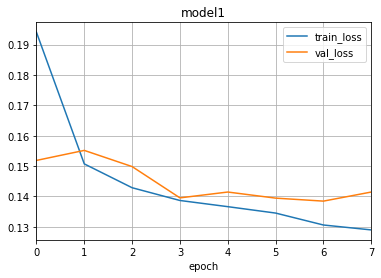

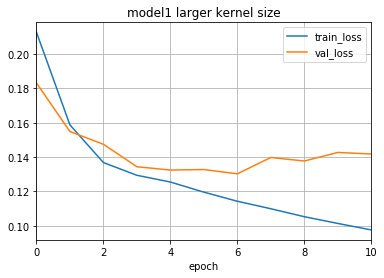

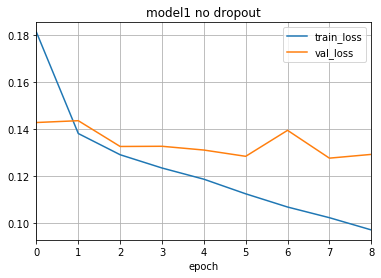

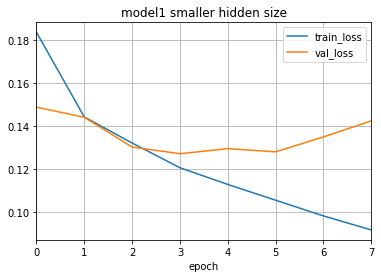

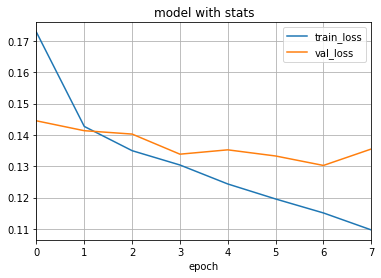

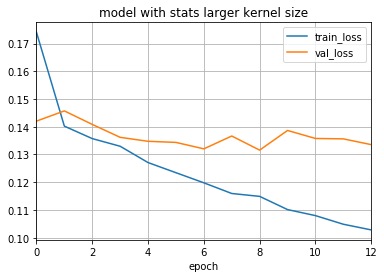

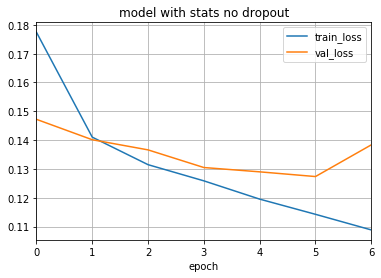

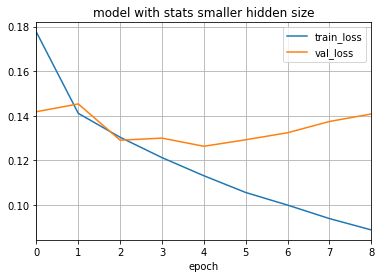

In [12]:
traj_dict = {}
for subdir in subdirs:
    model_name, traj_df = plot_trajectories(subdir)
    traj_dict[model_name] = traj_df

### Loss comparison across models

In [16]:
def plot_loss_comparison(loss_df, title):
    figure, ax = plt.subplots(figsize=(10, 8))
    
    loss_df.plot(ax=ax, 
                 title=title, 
                 legend=True, 
                 grid=True)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
val_loss_dict = {}
train_loss_dict = {}
for model_name, traj_df in traj_dict.items():
    val_loss_dict[model_name] = list(traj_df['val_loss'].values)
    train_loss_dict[model_name] = list(traj_df['train_loss'].values)

### - Validation Loss

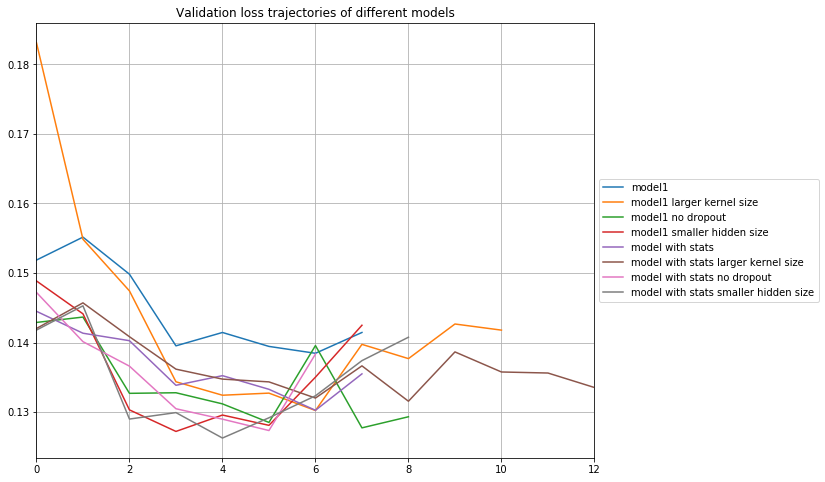

In [17]:
val_loss_df = pd.DataFrame.from_dict(val_loss_dict, orient='index')
val_loss_df = val_loss_df.transpose()

plot_loss_comparison(val_loss_df, 'Validation loss trajectories of different models')

### - Training Loss 
(Not much information but for the sake of completeness)

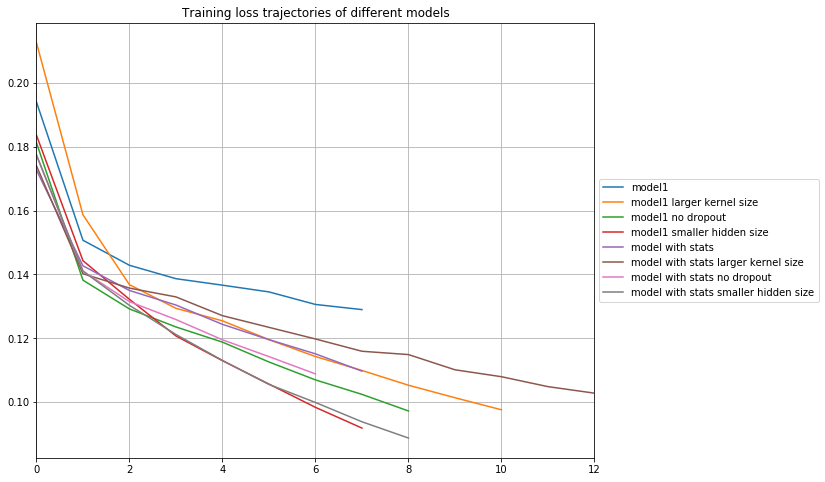

In [18]:
train_loss_df = pd.DataFrame.from_dict(train_loss_dict, orient='index')
train_loss_df = train_loss_df.transpose()

plot_loss_comparison(train_loss_df, 'Training loss trajectories of different models')

### Validation Loss Comparison Within Each Experiment

In [21]:
def plot_experiment_val_loss(val_loss_df, title, columns):
    """ Title contains information about the purpose of this experiment.
    Columns contain the model names that are relevant to this experiment. 
    """
    plot_df = val_loss_df[columns]
    
    title = 'Validation loss comparison: ' + title
    
    figure, ax = plt.subplots()
    
    plot_df.plot(ax=ax, 
                 title=title, 
                 legend=True, 
                 grid=True)
    

#### Experiments

In [24]:
experiments = {
    'effect of stats feature':
    ['model1', 'model with stats', 'model1 no dropout', 'model with stats no dropout'],
    'effect of dropout':
    ['model1', 'model1 no dropout', 'model with stats', 'model with stats no dropout'],
    'effect of a smaller LSTM hidden size': 
    ['model1', 'model1 smaller hidden size', 'model with stats', 'model with stats smaller hidden size'],
    'effect of a larger CNN kernel size':
    ['model1', 'model1 larger kernel size', 'model with stats', 'model with stats larger kernel size']
}


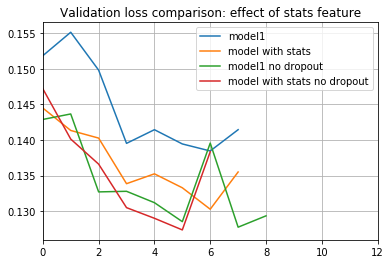

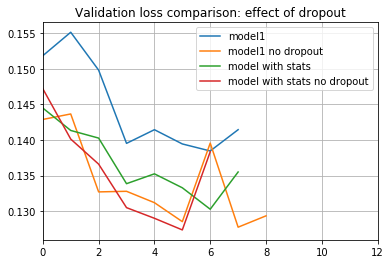

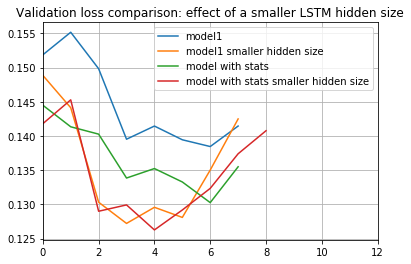

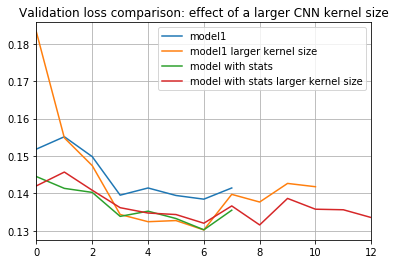

In [25]:
for title, columns in experiments.items():
    plot_experiment_val_loss(val_loss_df, title, columns)

In [26]:
experiments = {
    'effect of stats features with dropout': 
    ['model1', 'model with stats'],
    'effect of stats features without dropout': 
    ['model1 no dropout', 'model with stats no dropout'],
    'effect of dropout without stats features': 
    ['model1', 'model1 no dropout'],
    'effect of dropout with stats features': 
    ['model with stats', 'model with stats no dropout'],
    'effect of LSTM hidden size with stats features':
    ['model with stats', 'model with stats smaller hidden size'],
    'effect of LSTM hidden size without stats features':
    ['model1', 'model1 smaller hidden size'],
    'effect of CNN kernel size without stats features':
    ['model1', 'model1 larger kernel size'],
    'effect of CNN kernel size with stats features':
    ['model with stats', 'model with stats larger kernel size']
}

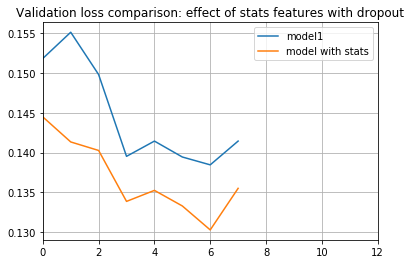

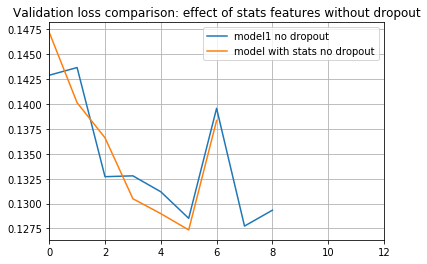

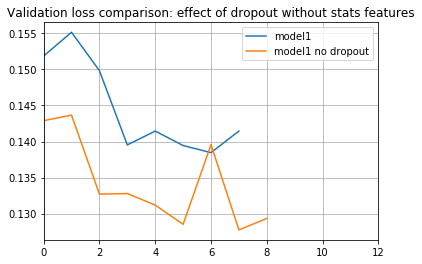

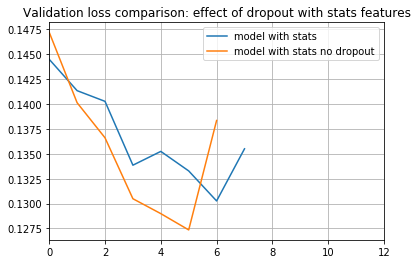

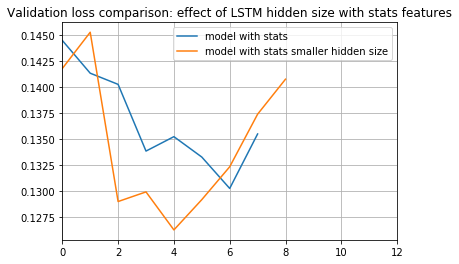

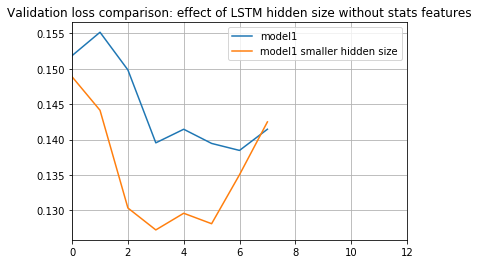

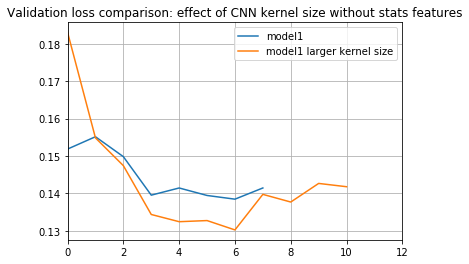

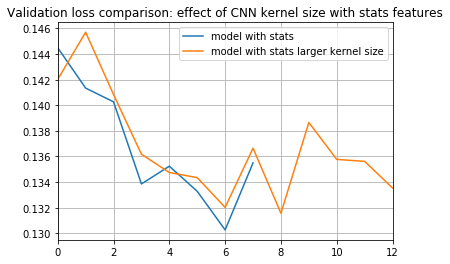

In [27]:
for title, columns in experiments.items():
    plot_experiment_val_loss(val_loss_df, title, columns)

### Observations
- **statistical features** improved model performance
- **dropout** layer seemed to decrease val loss
- **smaller hidden sizes** resulted in lower best val loss and earlier stopping
- **larger kernel size** reduced val loss in the baseline model, but not in the model with stats feature